# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [64]:
# import libraries here; 
# add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# magic word for producing visualizations in notebook
%matplotlib inline
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 1000)

import tensorflow as tf
import tensorflow_data_validation as tfdv


from sklearn.model_selection import train_test_split


from tensorflow_metadata.proto.v0 import schema_pb2

print ('TFDV version: {}'.format(tfdv.__version__))
print('Tensorflow Version:{}'.format(tf.__version__))

TFDV version: 0.30.0
Tensorflow Version:2.4.2


## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [65]:
# load in the data
german_population = pd.read_csv('germany_population.csv')
customers = pd.read_csv('customers_population.csv')

C:\Install\Anaconda3\envs\tens\lib\site-packages\IPython\core\interactiveshell.py:3172: DtypeWarning: Columns (18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [66]:
# Running a huge portion of the data can be very slow. You might reduce the number of instances for faster results.
german_population = german_population[:1000]

In [67]:
# Running a huge portion of the data can be very slow. You might reduce the number of instances for faster results.
customers=customers[:1000]

In [68]:
german_population.dtypes

LNR                              int64
AGER_TYP                         int64
AKT_DAT_KL                     float64
ALTER_HH                       float64
ALTER_KIND1                    float64
ALTER_KIND2                    float64
ALTER_KIND3                    float64
ALTER_KIND4                    float64
ALTERSKATEGORIE_FEIN           float64
ANZ_HAUSHALTE_AKTIV            float64
ANZ_HH_TITEL                   float64
ANZ_KINDER                     float64
ANZ_PERSONEN                   float64
ANZ_STATISTISCHE_HAUSHALTE     float64
ANZ_TITEL                      float64
ARBEIT                         float64
BALLRAUM                       float64
CAMEO_DEU_2015                  object
CAMEO_DEUG_2015                 object
CAMEO_INTL_2015                 object
CJT_GESAMTTYP                  float64
CJT_KATALOGNUTZER              float64
CJT_TYP_1                      float64
CJT_TYP_2                      float64
CJT_TYP_3                      float64
CJT_TYP_4                

Since we merge the data into one dataset to simplifiy data processing and feature transformation, we have to add a column named label. This column will serve as a guidance for us on which row belongs to which dataset. This will be helpful later when we apply unsupervised learning. 

In [69]:
ger_label =german_population['label']=0
cus_label =customers['label'] =1

In [70]:
german_customers = pd.concat([german_population, customers])

In [71]:
german_customers.label.value_counts()

0    1000
1    1000
Name: label, dtype: int64

In [72]:
try:
        coltype = type(german_customers.CAMEO_DEUG_2015.dropna().iloc[0])
except IndexError as e:
        #column is composed on only invalid values
        coltype = float
    
german_customers.CAMEO_DEUG_2015 = german_customers.CAMEO_DEUG_2015.astype(coltype)

In [73]:
try:
        coltype = type(german_customers.CAMEO_INTL_2015.dropna().iloc[0])
except IndexError as e:
        #column is composed on only invalid values
        coltype = float
    
german_customers.CAMEO_INTL_2015 = german_customers.CAMEO_INTL_2015.astype(coltype)

In [74]:
german_stats= tfdv.generate_statistics_from_dataframe(german_customers)

In [75]:
tfdv.visualize_statistics(german_stats)

To read the dictionary file, some packages are required if it is not installed in the machine. 

In [76]:
#!pip install xlrd
#!pip install openpyxl

In [77]:
attribute_excel = pd.read_excel(r'DIAS Attributes - Values 2017.xlsx', header=1)
attribute_excel

Unnamed: 0 Attribute         Description Value  \
0            NaN  AGER_TYP  best-ager typology    -1   
1            NaN       NaN                 NaN     0   
2            NaN       NaN                 NaN     1   
3            NaN       NaN                 NaN     2   
4            NaN       NaN                 NaN     3   
...          ...       ...                 ...   ...   
2253         NaN       NaN                 NaN     2   
2254         NaN       NaN                 NaN     3   
2255         NaN       NaN                 NaN     4   
2256         NaN       NaN                 NaN     5   
2257         NaN       NaN                 NaN     6   

                         Meaning  
0                        unknown  
1     no classification possible  
2                passive elderly  
3               cultural elderly  
4      experience-driven elderly  
...                          ...  
2253                       smart  
2254               fair supplied  
2255                price driven  
2256         seeking orientation  
2257                 indifferent  

[2258 rows x 5 columns]

In [78]:
# reading the second excel file
information_excel = pd.read_excel('DIAS Information Levels - Attributes 2017.xlsx')

In [79]:
information_excel.columns

Index(['Unnamed: 0', 'Unnamed: 1', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], dtype='object')

It seems the number of features differ from the data dictionary to the dataset. So, we will use set intersection to find the different features.

In [80]:
set_data_dict_features =set(information_excel['Unnamed: 0'][1:])

In [81]:
german_features =set(german_customers.columns).intersection(set_data_dict_features)

In [82]:
german_features

set()

After inspecting the dictionary file manually, we noticed that the indication of nulls could we mean "unkonwn" and "no transaction known". We create a variable and save these value to reference it using a query method.
Query is a new method in recent Pandas version that allows you to specifiy an SQL-like condition.

In [83]:
unknown = ["unknown","no transaction known"]
unknown_values = attribute_excel.query('Meaning == @unknown')

In [84]:
#unknown_values.drop('Unnamed: 0', axis =1, inplace = True)

So the first thing we do is to get a two column table showing for each feature what the corresponding null values are. Also, we can see that there are different features without an explanation since they do not exist in the excel files.
 so unknown_value is the dataframe wehere we have the features and the null values. W are going to process this file to match with each feature , what its null values

In [85]:
unknown_values

Unnamed: 0                    Attribute  \
0            NaN                     AGER_TYP   
5            NaN         ALTERSKATEGORIE_GROB   
33           NaN                    ANREDE_KZ   
40           NaN                     BALLRAUM   
48           NaN                     BIP_FLAG   
51           NaN              CAMEO_DEUG_2015   
105          NaN           CAMEO_DEUINTL_2015   
131          NaN                CJT_GESAMTTYP   
162          NaN         D19_BANKEN_DIREKT_RZ   
170          NaN          D19_BANKEN_GROSS_RZ   
178          NaN          D19_BANKEN_LOKAL_RZ   
217          NaN           D19_BANKEN_REST_RZ   
225          NaN        D19_BEKLEIDUNG_GEH_RZ   
233          NaN       D19_BEKLEIDUNG_REST_RZ   
241          NaN               D19_BILDUNG_RZ   
249          NaN              D19_BIO_OEKO_RZ   
257          NaN                  D19_BUCH_RZ   
265          NaN            D19_DIGIT_SERV_RZ   
273          NaN       D19_DROGERIEARTIKEL_RZ   
281          NaN               D19_ENERGIE_RZ   
289          NaN              D19_FREIZEIT_RZ   
297          NaN                D19_GARTEN_RZ   
360          NaN              D19_HANDWERK_RZ   
368          NaN             D19_HAUS_DEKO_RZ   
376          NaN         D19_KINDERARTIKEL_RZ   
391          NaN             D19_KK_KUNDENTYP   
398          NaN              D19_KOSMETIK_RZ   
406          NaN          D19_LEBENSMITTEL_RZ   
414          NaN                 D19_LOTTO_RZ   
422          NaN    D19_NAHRUNGSERGAENZUNG_RZ   
430          NaN              D19_RATGEBER_RZ   
438          NaN                D19_REISEN_RZ   
446          NaN         D19_SAMMELARTIKEL_RZ   
454          NaN                D19_SCHUHE_RZ   
462          NaN              D19_SONSTIGE_RZ   
470          NaN               D19_TECHNIK_RZ   
502          NaN          D19_TELKO_MOBILE_RZ   
530          NaN            D19_TELKO_REST_RZ   
538          NaN           D19_TIERARTIKEL_RZ   
601          NaN          D19_VERSAND_REST_RZ   
609          NaN        D19_VERSICHERUNGEN_RZ   
631          NaN         D19_VOLLSORTIMENT_RZ   
639          NaN         D19_WEIN_FEINKOST_RZ   
647          NaN                     EWDICHTE   
654          NaN                    FINANZTYP   
661          NaN               FINANZ_ANLEGER   
667          NaN             FINANZ_HAUSBAUER   
673          NaN            FINANZ_MINIMALIST   
679          NaN                FINANZ_SPARER   
685          NaN        FINANZ_UNAUFFAELLIGER   
691          NaN             FINANZ_VORSORGER   
697          NaN                  GEBAEUDETYP   
724          NaN                GEOSCORE_KLS7   
734          NaN            HAUSHALTSSTRUKTUR   
744          NaN                   HEALTH_TYP   
749          NaN           HH_EINKOMMEN_SCORE   
756          NaN                   INNENSTADT   
765          NaN                 KBA05_ALTER1   
771          NaN                 KBA05_ALTER2   
777          NaN                 KBA05_ALTER3   
783          NaN                 KBA05_ALTER4   
790          NaN                 KBA05_ANHANG   
795          NaN                  KBA05_ANTG1   
801          NaN                  KBA05_ANTG2   
807          NaN                  KBA05_ANTG3   
812          NaN                  KBA05_ANTG4   
821          NaN                          NaN   
822          NaN                 KBA05_BAUMAX   
828          NaN                   KBA05_CCM1   
834          NaN                   KBA05_CCM2   
840          NaN                   KBA05_CCM3   
846          NaN                   KBA05_CCM4   
852          NaN                 KBA05_DIESEL   
858          NaN                   KBA05_FRAU   
864          NaN                    KBA05_GBZ   
870          NaN                 KBA05_HERST1   
877          NaN                 KBA05_HERST2   
884          NaN                 KBA05_HERST3   
891          NaN                 KBA05_HERST4   
898          NaN                 KBA05_HERST5   
905          NaN              KBA05_H

only 266 features are reported to have missing values in the data dictionary (Excel File). Let's check the data itself.

There are different ways to acheive that. Let's go with pandas one using isna().sum(). 

In [86]:
sum (german_customers.isna().sum()>0)

276

This difference due to the fact that the features are not the same in the data dictionary and dataset. We will do merging later to get the common features

Before we go to start analysing the data, le's list all functions that we are going to use in the beggining of the notebook. So here we show all the functions:

    1. TensorFlow Data Validation.  (For Visualization)
    
    2. eda 
    
    3. feature inspection
    
    4. data processing
    
    5. merging
    
    6. dropping na
    
    7. transform features


let's check for customers

In [87]:
#############
#INPUT: Dataframe
#Output: Printing status.

# Purpose :This function shows the types, the total na in the datafram and in the column and the the description percentiles
############
def eda (dataset):
    print ('let''s check the columns types',  dataset.dtypes)
    print ('The total non-values in the dataset is',dataset.isna().sum().sum())
    print ('The total number in each columns' ,  dataset.isna().sum()) 
    print ('the precentiles of non-values ', dataset.isna().sum().describe(percentiles = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]))
       

In [88]:
#############
#INPUT: Dataframe, feature, value
#Output: replace passed values in the dataframe with NaN

# Purpose :Some features has abnormal values such as X..etc , so this function will reset it to Nan
############
def feature_inspection(dataset, feature, value):
    print ('let''s check the unique values in the feature CAMEO_DEUG_2015\n', dataset[feature].unique(), '\n' )
    dataset[dataset[feature] == value]
    dataset[feature] = dataset[feature].replace(value, np.nan)

In [89]:
#############
#INPUT: Dataframe
#Output: a processed column

# Purpose :for these two features, it drops their NA and convert them into float value.
############
def data_processing(dataset):
    
    try:
        #dataset[dataset.CAMEO_DEUG_2015 == 'X']
        dataset.CAMEO_DEUG_2015 = dataset.CAMEO_DEUG_2015.replace('X', np.nan)
        
        try:
            coltype = type(dataset.CAMEO_DEUG_2015.dropna().iloc[0])
            print ('Processing the column CAMEO_DEUG_2015 with X value is successful')
        except IndexError as e:
            #column is composed on only invalid values
            coltype = float
            dataset.CAMEO_DEUG_2015 = dataset.CAMEO_DEUG_2015.astype(coltype)
    except AttributeError:
        print(' The attribute CAMEO_DEUG_2015 does not exist in this chunk of data')
    
        

    
    try:
        dataset.CAMEO_INTL_2015 = dataset.CAMEO_INTL_2015.replace('XX', np.nan)
        coltype = type(dataset.CAMEO_INTL_2015.dropna().iloc[0])
        print ('Processing the column CAMEO_INTL_2015  with XX value is successful')
    except IndexError as e:
            #column is composed on only invalid values
        coltype = float
        dataset.CAMEO_INTL_2015 = dataset.CAMEO_INTL_2015.astype(coltype)
    except AttributeError:
        print('The attribute CAMEO_INTL_2015 does not exist in this chunk of data')
        

In [90]:
#############
#INPUT: Dataframe, data dictionary
#Output: a new dataframe

# Purpose :it checks for common features in the dataset and data dictionary and create a dataframe of these features where 
# values are checked if they are NaN value or not. This function takes alot of running time!
#############

def merging(dataset, data_dictionary):
    transposed = dataset.transpose().reset_index().rename(columns= {'index':'Attribute'})
    label = pd.DataFrame (dataset.label)
    merged =pd.merge (data_dictionary, transposed , on ="Attribute")
    merged =merged.set_index('Attribute').transpose()
    count=0
    for column in merged.columns:
        print(count )
        merged[column].apply(lambda x: np.nan if x in [merged[column].loc['Value']] else x)
        count = count +1
    #merged = merged.drop(['Value','Meaning'],axis = 0)
    merged.reset_index(inplace=True, drop=True)
    label.reset_index(inplace=True, drop=True)
    print(merged)
    merged =pd.concat ([merged, label], axis =1)
    

    return merged

In [91]:
#############
#INPUT: Dataframe, threshold for column, threshold for rows
#Output: processed dataframe 

# Purpose : it compares the null value in each column/row and compare it with the threshold. Above the threshold, then
# the column/row will be dropped
#############
def dropping_na(dataset, col_thresh, row_thresh):
    dropped_columns=[]
    for column in dataset.columns:
        if dataset[column].isna().sum() *100 /len(dataset)  >=col_thresh:
            dropped_columns.append(column)
   
    dataset.dropna(axis = 0 , thresh= row_thresh, inplace = True)
    dataset.drop(dropped_columns ,axis =1,inplace= True)

In [92]:
#############
#INPUT: Dataframe
#Output: processed dataframe 

# Purpose : Some features, has a list of values and thus merging function does not address them. Also,we discovered that there 
# are some values like W and O. In addition to transform all features into float. 
#############
def transform_features(dataset):
    dataset.replace('-1,0' , '-1', inplace = True)
    dataset.replace('W', '-1', inplace = True)
    dataset.replace('O', '-1', inplace = True)
    features_objects=["CJT_GESAMTTYP","PRODUCT_GROUP", "AGER_TYP", "TITEL_KZ", "D19_KK_KUNDENTYP","GEBAEUDETYP","GFK_URLAUBERTYP","LP_FAMILIE_FEIN",
               "LP_STATUS_FEIN","D19_KONSUMTYP","PRAEGENDE_JUGENDJAHRE","ZABEOTYP","CUSTOMER_GROUP","CAMEO_DEU_2015","CAMEO_INTL_2015"]
    

    for i in features_objects:
        if i in dataset.columns.values:
            
            features_cat=pd.get_dummies(dataset[i], prefix = i)
            dataset = pd.concat([dataset, features_cat], axis=1)
            dataset.drop(i,axis=1,inplace=True)
    
    
    
    
    try:
        dataset.drop(['D19_LETZTER_KAUF_BRANCHE'], inplace = True, axis = 1)
        dataset.drop(['EINGEFUEGT_AM'], inplace = True, axis = 1)
    except :
        print('The attribute/s are not in axis ')
    
    dataset[[col for col in dataset.columns if dataset[col].dtypes == object]].astype('float')

In [93]:
#############
#INPUT: Dataframe
#Output: print sparse features 

#The purpose: From the chart, we notice many variables has alot of missing values up to 98% sometimes. Also, some features are very sparse
#containing > 99% zero value.  So this to list all features that has more than 50% of their values as zeros.
#############
def inspect_nan_sparse(dataset):
    a =pd.DataFrame (dataset.isnull().sum()  * 100.0 / len (dataset) )
    a =a.reset_index()
    a[a[0]>50]['index']
    # so these are variables that has more than 50% of null values.let's check for zeros then
    sparse_features_count =0
    for column in dataset.columns:
       if (dataset[column] == 0).sum() *100.0 / len(dataset) > 50:
            print (f'the feature {column}  has more than 50% of their values are zeros')
            sparse_features_count +=1
    print (f' there are {sparse_features_count} features')

Now , since we explain the purpose of different functions above. We are going to use them throughout the notebook.

In [94]:
#this column has integer and string values. Also it has the value X. According to the data dictionary, X has no meaning there. 
#let's check how many X are there
feature_inspection(german_customers, 'CAMEO_DEU_2015', 'X')
feature_inspection(german_customers, 'CAMEO_DEUG_2015', 'X')
feature_inspection(german_customers, 'CAMEO_INTL_2015', 'XX')


lets check the unique values in the feature CAMEO_DEUG_2015
 [nan '8A' '4C' '2A' '6B' '8C' '4A' '2D' '1A' '1E' '9D' '5C' '8B' '7A' '5D'
 '9E' '9B' '1B' '3D' '4E' '4B' '3C' '5A' '7B' '9A' '6D' '6E' '2C' '7C'
 '9C' '7D' '5E' '1D' '8D' '6C' '6A' '5B' '4D' '3A' '2B' '7E' '3B' '6F'
 '5F' '1C'] 

lets check the unique values in the feature CAMEO_DEUG_2015
 [nan  8.  4.  2.  6.  1.  9.  5.  7.  3.] 

lets check the unique values in the feature CAMEO_DEUG_2015
 [nan 51. 24. 12. 43. 54. 22. 14. 13. 15. 33. 41. 34. 55. 25. 23. 31. 52.
 35. 45. 44. 32.] 



In [95]:
german_customers

LNR  AGER_TYP  AKT_DAT_KL  ALTER_HH  ALTER_KIND1  ALTER_KIND2  \
0    910215        -1         NaN       NaN          NaN          NaN   
1    910220        -1         9.0       0.0          NaN          NaN   
2    910225        -1         9.0      17.0          NaN          NaN   
3    910226         2         1.0      13.0          NaN          NaN   
4    910241        -1         1.0      20.0          NaN          NaN   
..      ...       ...         ...       ...          ...          ...   
995   87230        -1         NaN       NaN          NaN          NaN   
996   96374         1         1.0      19.0          NaN          NaN   
997   96376         1         1.0      11.0          NaN          NaN   
998   96382        -1         1.0      14.0          NaN          NaN   
999   96389        -1         2.0      20.0          NaN          NaN   

     ALTER_KIND3  ALTER_KIND4  ALTERSKATEGORIE_FEIN  ANZ_HAUSHALTE_AKTIV  \
0            NaN          NaN                   NaN                  NaN   
1            NaN          NaN                  21.0                 11.0   
2            NaN          NaN                  17.0                 10.0   
3            NaN          NaN                  13.0                  1.0   
4            NaN          NaN                  14.0                  3.0   
..           ...          ...                   ...                  ...   
995          NaN          NaN                   NaN                  NaN   
996          NaN          NaN                  13.0                  1.0   
997          NaN          NaN                  10.0                  2.0   
998          NaN          NaN                  14.0                  1.0   
999          NaN          NaN                  14.0                  1.0   

     ANZ_HH_TITEL  ANZ_KINDER  ANZ_PERSONEN  ANZ_STATISTISCHE_HAUSHALTE  \
0             NaN         NaN           NaN                         NaN   
1             0.0         0.0           2.0                        12.0   
2             0.0         0.0           1.0                         7.0   
3             0.0         0.0           0.0                         2.0   
4             0.0         0.0           4.0                         3.0   
..            ...         ...           ...                         ...   
995           NaN         NaN           NaN                         NaN   
996           0.0         0.0           4.0                         1.0   
997           0.0         0.0           3.0                         2.0   
998           0.0         0.0           2.0                         1.0   
999           0.0         0.0           3.0                         1.0   

     ANZ_TITEL  ARBEIT  BALLRAUM CAMEO_DEU_2015  CAMEO_DEUG_2015  \
0          NaN     NaN       NaN            NaN              NaN   
1          0.0     3.0       6.0             8A              8.0   
2          0.0     3.0       2.0             4C              4.0   
3          0.0     2.0       4.0             2A              2.0   
4          0.0     4.0       2.0             6B              6.0   
..         ...     ...       ...            ...              ...   
995        NaN     NaN       NaN            NaN              NaN   
996        0.0     3.0       6.0             2C              2.0   
997        0.0     3.0       7.0             3D              3.0   
998        0.0     4.0       3.0             4B              4.0   
999        0.0     1.0       6.0             6B              6.0   

     CAMEO_INTL_2015  CJT_GESAMTTYP  CJT_KATALOGNUTZER  CJT_TYP_1  CJT_TYP_2  \
0                NaN            2.0                5.0        1.0        1.0   
1               51.0            5.0                1.0        5.0        5.0   
2               24.0            3.0                2.0        4.0        4.0   
3               12.0            2.0                3.0        2.0        2.0   
4               43.0            5.0                3.0        3.0        3.0   
..               ...

In [96]:
german_customers.head()

LNR  AGER_TYP  AKT_DAT_KL  ALTER_HH  ALTER_KIND1  ALTER_KIND2  \
0  910215        -1         NaN       NaN          NaN          NaN   
1  910220        -1         9.0       0.0          NaN          NaN   
2  910225        -1         9.0      17.0          NaN          NaN   
3  910226         2         1.0      13.0          NaN          NaN   
4  910241        -1         1.0      20.0          NaN          NaN   

   ALTER_KIND3  ALTER_KIND4  ALTERSKATEGORIE_FEIN  ANZ_HAUSHALTE_AKTIV  \
0          NaN          NaN                   NaN                  NaN   
1          NaN          NaN                  21.0                 11.0   
2          NaN          NaN                  17.0                 10.0   
3          NaN          NaN                  13.0                  1.0   
4          NaN          NaN                  14.0                  3.0   

   ANZ_HH_TITEL  ANZ_KINDER  ANZ_PERSONEN  ANZ_STATISTISCHE_HAUSHALTE  \
0           NaN         NaN           NaN                         NaN   
1           0.0         0.0           2.0                        12.0   
2           0.0         0.0           1.0                         7.0   
3           0.0         0.0           0.0                         2.0   
4           0.0         0.0           4.0                         3.0   

   ANZ_TITEL  ARBEIT  BALLRAUM CAMEO_DEU_2015  CAMEO_DEUG_2015  \
0        NaN     NaN       NaN            NaN              NaN   
1        0.0     3.0       6.0             8A              8.0   
2        0.0     3.0       2.0             4C              4.0   
3        0.0     2.0       4.0             2A              2.0   
4        0.0     4.0       2.0             6B              6.0   

   CAMEO_INTL_2015  CJT_GESAMTTYP  CJT_KATALOGNUTZER  CJT_TYP_1  CJT_TYP_2  \
0              NaN            2.0                5.0        1.0        1.0   
1             51.0            5.0                1.0        5.0        5.0   
2             24.0            3.0                2.0        4.0        4.0   
3             12.0            2.0                3.0        2.0        2.0   
4             43.0            5.0                3.0        3.0        3.0   

   CJT_TYP_3  CJT_TYP_4  CJT_TYP_5  CJT_TYP_6  D19_BANKEN_ANZ_12  \
0        5.0        5.0        5.0        5.0                  0   
1        2.0        3.0        1.0        1.0                  0   
2        1.0        3.0        2.0        2.0                  0   
3        4.0        4.0        5.0        3.0                  0   
4        3.0        4.0        3.0        3.0                  3   

   D19_BANKEN_ANZ_24  D19_BANKEN_DATUM  D19_BANKEN_DIREKT  D19_BANKEN_GROSS  \
0                  0                10                  0                 0   
1                  0                10                  0                 0   
2                  0                10                  0                 0   
3                  0                10                  0                 0   
4                  5                 5                  1                 2   

   D19_BANKEN_LOKAL  D19_BANKEN_OFFLINE_DATUM  D19_BANKEN_ONLINE_DATUM  \
0                 0                        10                       10   
1                 0                        10                       10   
2                 0                        10                       10   
3                 0                        10                       10   
4                 0                        10                        5   

   D19_BANKEN_ONLINE_QUOTE_12  D19_BANKEN_REST  D19_BEKLEIDUNG_GEH  \
0                         NaN                0                   0   
1                         NaN                0                   0   
2                         0.0                0                   0   
3                         0.0                0                   0   
4                        10.0                6                   6   

   D19_BEKLEIDUNG_REST  D19_BILDUNG  D19_BIO_OEKO  D19_BUCH_CD  \
0            

In [97]:
inspect_nan_sparse(german_customers)

the feature ANZ_HH_TITEL  has more than 50% of their values are zeros
the feature ANZ_KINDER  has more than 50% of their values are zeros
the feature ANZ_TITEL  has more than 50% of their values are zeros
the feature D19_BANKEN_ANZ_12  has more than 50% of their values are zeros
the feature D19_BANKEN_ANZ_24  has more than 50% of their values are zeros
the feature D19_BANKEN_DIREKT  has more than 50% of their values are zeros
the feature D19_BANKEN_GROSS  has more than 50% of their values are zeros
the feature D19_BANKEN_LOKAL  has more than 50% of their values are zeros
the feature D19_BANKEN_ONLINE_QUOTE_12  has more than 50% of their values are zeros
the feature D19_BANKEN_REST  has more than 50% of their values are zeros
the feature D19_BEKLEIDUNG_GEH  has more than 50% of their values are zeros
the feature D19_BEKLEIDUNG_REST  has more than 50% of their values are zeros
the feature D19_BILDUNG  has more than 50% of their values are zeros
the feature D19_BIO_OEKO  has more than 50%

In [98]:
data_processing(german_customers)

Processing the column CAMEO_DEUG_2015 with X value is successful
Processing the column CAMEO_INTL_2015  with XX value is successful


In [99]:
german_customers =merging(german_customers, unknown_values)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
Attribute            AGER_TYP                          ALTERSKATEGORIE_GROB  \
0                         NaN                                           NaN   
1          best-ager typology  age classification through prenam

After the merging, there are some additional rows from the dictionary file. The first is the column title and the second is the null values representation. Thus, we are going to consider the dataframe from row 2 onward.

In [100]:
german_customers=german_customers.reset_index(drop = True)

In [101]:
german_customers[2:]

AGER_TYP ALTERSKATEGORIE_GROB ANREDE_KZ BALLRAUM CAMEO_DEUG_2015  \
2          -1                -1, 0     -1, 0       -1              -1   
3     unknown              unknown   unknown  unknown         unknown   
4          -1                    2         1      NaN             NaN   
5          -1                    1         2      6.0             8.0   
6          -1                    3         2      2.0             4.0   
...       ...                  ...       ...      ...             ...   
1999       -1                    1         2      NaN             NaN   
2000        1                    4         1      6.0             2.0   
2001        1                    3         1      7.0             3.0   
2002       -1                    4         2      3.0             4.0   
2003       -1                    3         2      6.0             6.0   

     CJT_GESAMTTYP EWDICHTE FINANZTYP FINANZ_ANLEGER FINANZ_HAUSBAUER  \
2                0       -1        -1             -1               -1   
3          unknown  unknown   unknown        unknown          unknown   
4              2.0      NaN         4              5                3   
5              5.0      3.0         1              5                5   
6              3.0      4.0         1              2                5   
...            ...      ...       ...            ...              ...   
1999           6.0      NaN         4              5                3   
2000           5.0      2.0         6              1                1   
2001           2.0      2.0         5              1                2   
2002           2.0      4.0         6              3                1   
2003           5.0      2.0         6              4                1   

     FINANZ_MINIMALIST FINANZ_SPARER FINANZ_UNAUFFAELLIGER FINANZ_VORSORGER  \
2                   -1            -1                    -1               -1   
3              unknown       unknown               unknown          unknown   
4                    3             4                     5                3   
5                    1             5                     4                2   
6                    1             4                     3                1   
...                ...           ...                   ...              ...   
1999                 3             4                     5                3   
2000                 5             1                     1                5   
2001                 5             1                     2                5   
2002                 5             2                     3                4   
2003                 4             2                     2                4   

     GEBAEUDETYP HEALTH_TYP HH_EINKOMMEN_SCORE INNENSTADT KBA05_ALTER1  \
2          -1, 0         -1              -1, 0         -1        -1, 9   
3        unknown    unknown            unknown    unknown      unknown   
4            NaN         -1                2.0        NaN          NaN   
5            8.0          3                6.0        8.0          3.0   
6            1.0          3                4.0        4.0          2.0   
...          ...        ...                ...        ...          ...   
1999         NaN         -1                2.0        NaN          NaN   
2000         8.0          2                1.0        8.0          1.0   
2001         3.0          3                3.0        8.0          3.0   
2002         1.0          1                4.0        5.0          1.0   
2003         1.0          3                3.0        5.0          0.0   

     KBA05_ALTER2 KBA05_ALTER3 KBA05_ALTER4 KBA05_ANHANG KBA05_ANTG1  \
2           -1, 9        -1, 9        -1, 9        -1, 9          -1   
3         unknown      unknown      unknown      unknown     unknown   
4             NaN          NaN          NaN          NaN         NaN   
5             4.0          1.0          4.0          0.0         0.0   
6             3.0          3.0          3.0          

Now the question, what to drop? This is a crucial question and differs from one data to another. the data here has hundreds of features and hundred thousands of rows, so if there are a 1000 null value, we can drop the lines, the other hundred thousands can still give us a clue about the underlying pattern. 

Thus, for this type of data, we will create a strategy:
1) for column based: we notice many columns has very high values. Dropping these features early is not helpful since we might lose information. So, by going through these data, we notice
2) row_based: if a row has so many nulls, then we should not plug any value in the columns. Since across different features, the reading value is missing and better to be dropped.






# dropping Nulls

In [102]:
# since we are not going to reference these dfs many times, it is better to reuse the df name, rather than creating a
#confusing one everytime. Hence, temp_df will be reused.
temp_df=german_customers.isna().sum() *100 / len(german_customers)

In [103]:
temp_df.describe(percentiles =[0.75,0.8,0.81,0.82,.83,0.84,0.85,0.9,0.95])
#perfect so based on these distribution , we can set up the threshold for number of nulls in the column in order to qualify to 
# be dropped

count    223.000000
mean      26.579800
std       11.286519
min        0.049900
50%       30.688623
75%       32.784431
80%       32.784431
81%       32.784431
82%       32.784431
83%       32.784431
84%       32.784431
85%       32.784431
90%       32.784431
95%       32.784431
max       32.784431
dtype: float64

In [104]:
temp_df=german_customers.transpose().isna().sum()

In [105]:
# let's describe the transposed of the df. This helps us to decide the threshold for null values in each row.
# temp_df.describe()
# We noticed that the there are some rows in which 22 features are missing. This is bad. These rows should be droppped.
# So as the column, this help us to set the threshold for rows.

In [106]:
temp_df.describe()

count    2004.000000
mean       59.272954
std        86.097884
min         0.000000
25%         0.000000
50%         0.000000
75%       189.000000
max       222.000000
dtype: float64

In [107]:
temp_df.describe(percentiles=[0.8,.85,0.86,0.87,0.88,0.89,.90,.95, 0.96,0.97,0.98,0.99])# will retain 95% of features from 366. 

count    2004.000000
mean       59.272954
std        86.097884
min         0.000000
50%         0.000000
80%       189.000000
85%       189.000000
86%       189.000000
87%       189.000000
88%       189.000000
89%       189.000000
90%       189.000000
95%       189.000000
96%       189.000000
97%       189.000000
98%       189.000000
99%       189.000000
max       222.000000
dtype: float64

In [108]:
col_thresh = 25
row_thresh = 190
dropping_na(german_customers, col_thresh, row_thresh)

The dataframe is not clean yet. We only drop some rows and columns. for the other NaN values, it is better to fill them
We use the mean of each column

In [109]:
german_customers= german_customers.fillna(german_customers.mean())
# not all nulls are filled due to -1,0 value 

In [110]:
german_customers.dropna(inplace = True)

In [111]:
german_customers.isna().sum().sum()

0

### Note: since we combine german and customers dataset into one dataframe, so all processing are applied to both of them.

# Feature Engineering

Le't check for correlation. If two feature has an absloute correlation of more than 0.8 percent, we can drop one of them.

In [112]:
def corr(dataset):
    corr_df =  german_customers.corr()
    corr_df = corr_df.abs()
    corr_df = corr_df [(corr_df > 0.80) & (corr_df < 1.0)]
    

In [113]:
corr_features_to_drop = ['KBA13_BAUMAX', 'D19_TELKO_ANZ_24' , 'D19_BANKEN_ONLINE_DATUM' , 'D19_BANKEN_ANZ_24',
                         'LP_STATUS_FEIN'  , 'D19_VERSAND_ANZ_12' , 'D19_GESAMT_ONLINE_DATUM', 'D19_GESAMT_ANZ_12',
                         'D19_VERSAND_ANZ_24', 'D19_GESAMT_ANZ_24' ,'D19_VERSAND_DATUM', 'D19_VERSAND_ONLINE_DATUM',
                         'D19_GESAMT_DATUM', 'VK_DHT4A', 'VK_ZG11', 'CJT_TYP_1','LP_LEBENSPHASE_FEIN',
                         'ANZ_STATISTISCHE_HAUSHALTE', 'CJT_TYP_5' ]
try:
    german_customers.drop(corr_features_to_drop, axis = 1, inplace = True)
except KeyError:
    pass

### Note: We tried to extract the correlated feature automatically. However, due to the size of the matrix, it shows
### us an error. Thus, we record it manually.

1. KBA13_BAUMAX and PLZ8_BAUMAX
2. D19_TELKO_ANZ_24 and D19_TELKO_DATUM
3. D19_BANKEN_ONLINE_DATUM and D19_BANKEN_DATUM and D19_BANKEN_ANZ_24
4. LP_STATUS_FEIN and LP_STATUS_GROB
5. D19_GESAMT_ONLINE_DATUM and D19_VERSAND_ANZ_24 and D19_GESAMT_ANZ_24 and D19_VERSAND_DATUM and D19_VERSAND_ONLINE_DATUM
D19_GESAMT_DATUM
6. D19_VERSAND_ANZ_12 : D19_GESAMT_ANZ_12 and D19_VERSAND_ANZ_24 and D19_GESAMT_ANZ_24 
7.D19_GESAMT_ANZ_12 and D19_VERSAND_ANZ_24 and D19_GESAMT_ANZ_24 and D19_GESAMT_DATUM

8 D19_VERSAND_ANZ_24 and D19_GESAMT_ANZ_24 and D19_VERSAND_DATUM and D19_VERSAND_ONLINE_DATUM

9 VK_DISTANZ and VK_DHT4A and  VK_ZG11

10 CJT_TYP_2 and CJT_TYP_1

11 D19_BANKEN_ANZ_24 and D19_BANKEN_ANZ_12

12 LP_FAMILIE_FEIN  and LP_LEBENSPHASE_FEIN

13 ANZ_HAUSHALTE_AKTIV and ANZ_STATISTISCHE_HAUSHALTE

14 CJT_TYP_5 and CJT_TYP_1

15 D19_KONSUMTYP_MAX and D19_GESAMT_DATUM




















#  Here, we wanted to inspect different features individaully to enhance our
# results. Many of the above functions and processings is a result of our observation to what happens here.  We commented the code now.

In [114]:
# now we want to check value distribution in some features that the discription int eh data dictionary was not clear

#german_customers['ALTERSKATEGORIE_GROB'].value_counts() # there are 2753 values of 9 (not clear). So , we can drop these rows

In [115]:
#cleaned_german_population['ALTER_HH'].value_counts() # 21 values are there for a period of 4years. 
# 0 will be dropped. and 1-7 will be grouped together in one bucket.

In [116]:
#cleaned_german_population['CAMEO_DEU_2015'].value_counts() # needs to be splitted into two tables. Letter and digit

In [117]:
#cleaned_german_population['EWDICHTE'].value_counts()


In [118]:
#cleaned_german_population['INNENSTADT'].value_counts()

In [119]:
#cleaned_german_population['KBA05_GBZ'].value_counts()


####  so here, we do a final checking that the dataframe in the suitable form to be
#### fed to ML

In [120]:
german_customers.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1327 entries, 1 to 2003
Data columns (total 34 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   AGER_TYP               1327 non-null   object 
 1   ALTERSKATEGORIE_GROB   1327 non-null   object 
 2   ANREDE_KZ              1327 non-null   object 
 3   CJT_GESAMTTYP          1327 non-null   object 
 4   FINANZTYP              1327 non-null   object 
 5   FINANZ_ANLEGER         1327 non-null   object 
 6   FINANZ_HAUSBAUER       1327 non-null   object 
 7   FINANZ_MINIMALIST      1327 non-null   object 
 8   FINANZ_SPARER          1327 non-null   object 
 9   FINANZ_UNAUFFAELLIGER  1327 non-null   object 
 10  FINANZ_VORSORGER       1327 non-null   object 
 11  HEALTH_TYP             1327 non-null   object 
 12  HH_EINKOMMEN_SCORE     1327 non-null   object 
 13  NATIONALITAET_KZ       1327 non-null   object 
 14  PRAEGENDE_JUGENDJAHRE  1327 non-null   object 
 15  RETO

In [121]:
german_customers= german_customers[4:]

In [122]:
german_customers

AGER_TYP ALTERSKATEGORIE_GROB ANREDE_KZ CJT_GESAMTTYP FINANZTYP  \
6          -1                    3         2           3.0         1   
7           2                    4         2           2.0         6   
8          -1                    3         1           5.0         5   
9           3                    1         2           2.0         2   
10         -1                    2         2           5.0         4   
...       ...                  ...       ...           ...       ...   
1998        1                    4         1           2.0         5   
2000        1                    4         1           5.0         6   
2001        1                    3         1           2.0         5   
2002       -1                    4         2           2.0         6   
2003       -1                    3         2           5.0         6   

     FINANZ_ANLEGER FINANZ_HAUSBAUER FINANZ_MINIMALIST FINANZ_SPARER  \
6                 2                5                 1             4   
7                 2                2                 4             2   
8                 1                2                 4             3   
9                 2                5                 3             1   
10                5                3                 1             5   
...             ...              ...               ...           ...   
1998              1                2                 5             1   
2000              1                1                 5             1   
2001              1                2                 5             1   
2002              3                1                 5             2   
2003              4                1                 4             2   

     FINANZ_UNAUFFAELLIGER FINANZ_VORSORGER HEALTH_TYP HH_EINKOMMEN_SCORE  \
6                        3                1          3                4.0   
7                        1                5          2                1.0   
8                        3                4          3                5.0   
9                        2                5          3                5.0   
10                       4                1          2                6.0   
...                    ...              ...        ...                ...   
1998                     1                5          1                3.0   
2000                     1                5          2                1.0   
2001                     2                5          3                3.0   
2002                     3                4          1                4.0   
2003                     2                4          3                3.0   

     NATIONALITAET_KZ PRAEGENDE_JUGENDJAHRE RETOURTYP_BK_S SEMIO_DOM  \
6                   1                    15            3.0         7   
7                   1                     8            2.0         4   
8                   1                     8            5.0         2   
9                   1                     3            3.0         4   
10                  1                    10            4.0         4   
...               ...                   ...            ...       ...   
1998                1                     2            3.0         1   
2000                1                     9            2.0         3   
2001                1                     4            3.0         5   
2002                1                     8            5.0         5   
2003                1                     8            3.0         4   

     SEMIO_ERL SEMIO_FAM SEMIO_KAEM SEMIO_KRIT SEMIO_KULT SEMIO_LUST  \
6            6         1          7          7          3          4   
7            7         1          5          4          4          4   
8            4         4          2          3          6          4   
9            2         4          4          4          5          2   
10           5         5          7          7          5          6   
...        ...       ...        ...        ...       

In [123]:
german_customers.dtypes

AGER_TYP                  object
ALTERSKATEGORIE_GROB      object
ANREDE_KZ                 object
CJT_GESAMTTYP             object
FINANZTYP                 object
FINANZ_ANLEGER            object
FINANZ_HAUSBAUER          object
FINANZ_MINIMALIST         object
FINANZ_SPARER             object
FINANZ_UNAUFFAELLIGER     object
FINANZ_VORSORGER          object
HEALTH_TYP                object
HH_EINKOMMEN_SCORE        object
NATIONALITAET_KZ          object
PRAEGENDE_JUGENDJAHRE     object
RETOURTYP_BK_S            object
SEMIO_DOM                 object
SEMIO_ERL                 object
SEMIO_FAM                 object
SEMIO_KAEM                object
SEMIO_KRIT                object
SEMIO_KULT                object
SEMIO_LUST                object
SEMIO_MAT                 object
SEMIO_PFLICHT             object
SEMIO_RAT                 object
SEMIO_REL                 object
SEMIO_SOZ                 object
SEMIO_TRADV               object
SEMIO_VERT                object
SHOPPER_TY

In [124]:
transform_features(german_customers)

The attribute/s are not in axis 


In [125]:
german_customers.AGER_TYP

6       -1
7        2
8       -1
9        3
10      -1
        ..
1998     1
2000     1
2001     1
2002    -1
2003    -1
Name: AGER_TYP, Length: 1323, dtype: object

In [126]:
german_customers

AGER_TYP ALTERSKATEGORIE_GROB ANREDE_KZ CJT_GESAMTTYP FINANZTYP  \
6          -1                    3         2           3.0         1   
7           2                    4         2           2.0         6   
8          -1                    3         1           5.0         5   
9           3                    1         2           2.0         2   
10         -1                    2         2           5.0         4   
...       ...                  ...       ...           ...       ...   
1998        1                    4         1           2.0         5   
2000        1                    4         1           5.0         6   
2001        1                    3         1           2.0         5   
2002       -1                    4         2           2.0         6   
2003       -1                    3         2           5.0         6   

     FINANZ_ANLEGER FINANZ_HAUSBAUER FINANZ_MINIMALIST FINANZ_SPARER  \
6                 2                5                 1             4   
7                 2                2                 4             2   
8                 1                2                 4             3   
9                 2                5                 3             1   
10                5                3                 1             5   
...             ...              ...               ...           ...   
1998              1                2                 5             1   
2000              1                1                 5             1   
2001              1                2                 5             1   
2002              3                1                 5             2   
2003              4                1                 4             2   

     FINANZ_UNAUFFAELLIGER FINANZ_VORSORGER HEALTH_TYP HH_EINKOMMEN_SCORE  \
6                        3                1          3                4.0   
7                        1                5          2                1.0   
8                        3                4          3                5.0   
9                        2                5          3                5.0   
10                       4                1          2                6.0   
...                    ...              ...        ...                ...   
1998                     1                5          1                3.0   
2000                     1                5          2                1.0   
2001                     2                5          3                3.0   
2002                     3                4          1                4.0   
2003                     2                4          3                3.0   

     NATIONALITAET_KZ PRAEGENDE_JUGENDJAHRE RETOURTYP_BK_S SEMIO_DOM  \
6                   1                    15            3.0         7   
7                   1                     8            2.0         4   
8                   1                     8            5.0         2   
9                   1                     3            3.0         4   
10                  1                    10            4.0         4   
...               ...                   ...            ...       ...   
1998                1                     2            3.0         1   
2000                1                     9            2.0         3   
2001                1                     4            3.0         5   
2002                1                     8            5.0         5   
2003                1                     8            3.0         4   

     SEMIO_ERL SEMIO_FAM SEMIO_KAEM SEMIO_KRIT SEMIO_KULT SEMIO_LUST  \
6            6         1          7          7          3          4   
7            7         1          5          4          4          4   
8            4         4          2          3          6          4   
9            2         4          4          4          5          2   
10           5         5          7          7          5          6   
...        ...       ...        ...        ...       

In [127]:
german_customers

AGER_TYP ALTERSKATEGORIE_GROB ANREDE_KZ CJT_GESAMTTYP FINANZTYP  \
6          -1                    3         2           3.0         1   
7           2                    4         2           2.0         6   
8          -1                    3         1           5.0         5   
9           3                    1         2           2.0         2   
10         -1                    2         2           5.0         4   
...       ...                  ...       ...           ...       ...   
1998        1                    4         1           2.0         5   
2000        1                    4         1           5.0         6   
2001        1                    3         1           2.0         5   
2002       -1                    4         2           2.0         6   
2003       -1                    3         2           5.0         6   

     FINANZ_ANLEGER FINANZ_HAUSBAUER FINANZ_MINIMALIST FINANZ_SPARER  \
6                 2                5                 1             4   
7                 2                2                 4             2   
8                 1                2                 4             3   
9                 2                5                 3             1   
10                5                3                 1             5   
...             ...              ...               ...           ...   
1998              1                2                 5             1   
2000              1                1                 5             1   
2001              1                2                 5             1   
2002              3                1                 5             2   
2003              4                1                 4             2   

     FINANZ_UNAUFFAELLIGER FINANZ_VORSORGER HEALTH_TYP HH_EINKOMMEN_SCORE  \
6                        3                1          3                4.0   
7                        1                5          2                1.0   
8                        3                4          3                5.0   
9                        2                5          3                5.0   
10                       4                1          2                6.0   
...                    ...              ...        ...                ...   
1998                     1                5          1                3.0   
2000                     1                5          2                1.0   
2001                     2                5          3                3.0   
2002                     3                4          1                4.0   
2003                     2                4          3                3.0   

     NATIONALITAET_KZ PRAEGENDE_JUGENDJAHRE RETOURTYP_BK_S SEMIO_DOM  \
6                   1                    15            3.0         7   
7                   1                     8            2.0         4   
8                   1                     8            5.0         2   
9                   1                     3            3.0         4   
10                  1                    10            4.0         4   
...               ...                   ...            ...       ...   
1998                1                     2            3.0         1   
2000                1                     9            2.0         3   
2001                1                     4            3.0         5   
2002                1                     8            5.0         5   
2003                1                     8            3.0         4   

     SEMIO_ERL SEMIO_FAM SEMIO_KAEM SEMIO_KRIT SEMIO_KULT SEMIO_LUST  \
6            6         1          7          7          3          4   
7            7         1          5          4          4          4   
8            4         4          2          3          6          4   
9            2         4          4          4          5          2   
10           5         5          7          7          5          6   
...        ...       ...        ...        ...       

In [128]:
german_customers.columns

Index(['AGER_TYP', 'ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'CJT_GESAMTTYP',
       'FINANZTYP', 'FINANZ_ANLEGER', 'FINANZ_HAUSBAUER', 'FINANZ_MINIMALIST',
       'FINANZ_SPARER', 'FINANZ_UNAUFFAELLIGER', 'FINANZ_VORSORGER',
       'HEALTH_TYP', 'HH_EINKOMMEN_SCORE', 'NATIONALITAET_KZ',
       'PRAEGENDE_JUGENDJAHRE', 'RETOURTYP_BK_S', 'SEMIO_DOM', 'SEMIO_ERL',
       'SEMIO_FAM', 'SEMIO_KAEM', 'SEMIO_KRIT', 'SEMIO_KULT', 'SEMIO_LUST',
       'SEMIO_MAT', 'SEMIO_PFLICHT', 'SEMIO_RAT', 'SEMIO_REL', 'SEMIO_SOZ',
       'SEMIO_TRADV', 'SEMIO_VERT', 'SHOPPER_TYP', 'VERS_TYP', 'ZABEOTYP',
       'label'],
      dtype='object')

## Part 1: Customer Segmentation Report



In [130]:
# scaling all features.
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
ss=ss.fit_transform(german_customers)


In [131]:
from sklearn.cluster import KMeans

In [132]:
clusters_distance=[]
for k in range(3,20):
    kmeans = KMeans(n_clusters=k).fit(ss)
    clusters_distance.append(kmeans.inertia_)

Text(0, 0.5, 'SSE')

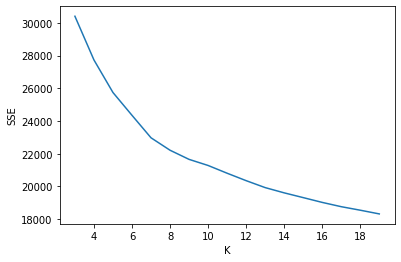

In [133]:
# we used different range here from time to time. But at the end, we settled to this one.
plt.plot(range(3,20),clusters_distance)
plt.xlabel("K")
plt.ylabel("SSE")

It seems different values can be a good candidate for k. Not a fully elbow shape is formed but we can see that after 10 the cluster distance reduction is not significant. We will go for 6 clusters

In [134]:
# Comparing to customer data

k=6

model = KMeans(n_clusters=k).fit(ss)

# we split the datasets into two datasets using the key label that we set in the start.
customers=german_customers[german_customers.label ==1]
germans=german_customers[german_customers.label ==0]


C:\Install\Anaconda3\envs\tens\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(
C:\Install\Anaconda3\envs\tens\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(


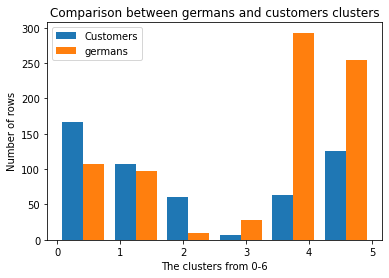

In [135]:
cust=model.predict(customers)
ger=model.predict(germans)
plt.hist([cust, ger],label=['Customers', 'germans'],bins=k)
plt.title('Comparison between germans and customers clusters')
plt.xlabel("The clusters from 0-6")
plt.ylabel("Number of rows")
plt.legend()

From the chart, we can see that cluster 4 are largerly from customers while cluster 5 is largely represents the german population.
On the other hand, it seems for cluster 1 and and 2 we successfully can see similarity between customers and general population.

## Part 2: Supervised Learning Model

We have used modularity in this project and it will help us now. We just have to call the functions again in this part.

In [207]:
mailout_train = pd.read_csv('mailout_train.csv')[:5000]
mailout_test =   pd.read_csv('mailout_test.csv')[:5000]

C:\Install\Anaconda3\envs\tens\lib\site-packages\IPython\core\interactiveshell.py:3172: DtypeWarning: Columns (19,20) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [208]:
# the merging function takes a lot of time when we take the whole data. Thus, we are going to take a portion only of the data.
mailout_train

Unnamed: 0    LNR  AGER_TYP  AKT_DAT_KL  ALTER_HH  ALTER_KIND1  \
0              0   1763         2         1.0       8.0          NaN   
1              1   1771         1         4.0      13.0          NaN   
2              2   1776         1         1.0       9.0          NaN   
3              3   1460         2         1.0       6.0          NaN   
4              4   1783         2         1.0       9.0          NaN   
...          ...    ...       ...         ...       ...          ...   
4995        4995  51043         2         1.0      10.0          NaN   
4996        4996  51357        -1         1.0      14.0          NaN   
4997        4997  51699         2         1.0       7.0          NaN   
4998        4998  52016         2         1.0       4.0          NaN   
4999        4999  52348         1         1.0      11.0          NaN   

      ALTER_KIND2  ALTER_KIND3  ALTER_KIND4  ALTERSKATEGORIE_FEIN  \
0             NaN          NaN          NaN                   8.0   
1             NaN          NaN          NaN                  13.0   
2             NaN          NaN          NaN                   7.0   
3             NaN          NaN          NaN                   6.0   
4             NaN          NaN          NaN                   9.0   
...           ...          ...          ...                   ...   
4995          NaN          NaN          NaN                  10.0   
4996          NaN          NaN          NaN                  14.0   
4997          NaN          NaN          NaN                   7.0   
4998          NaN          NaN          NaN                   4.0   
4999          NaN          NaN          NaN                  11.0   

      ANZ_HAUSHALTE_AKTIV  ANZ_HH_TITEL  ANZ_KINDER  ANZ_PERSONEN  \
0                    15.0           0.0         0.0           1.0   
1                     1.0           0.0         0.0           2.0   
2                     0.0           NaN         0.0           0.0   
3                     4.0           0.0         0.0           2.0   
4                    53.0           0.0         0.0           1.0   
...                   ...           ...         ...           ...   
4995                 10.0           0.0         0.0           1.0   
4996                  1.0           0.0         0.0           2.0   
4997                  7.0           0.0         0.0           1.0   
4998                  2.0           0.0         0.0           1.0   
4999                  1.0           0.0         0.0           2.0   

      ANZ_STATISTISCHE_HAUSHALTE  ANZ_TITEL  ARBEIT  BALLRAUM CAMEO_DEU_2015  \
0                           13.0        0.0     3.0       5.0             5D   
1                            1.0        0.0     2.0       5.0             5B   
2                            1.0        0.0     4.0       1.0             2D   
3                            4.0        0.0     4.0       2.0             2D   
4                           44.0        0.0     3.0       4.0             7B   
...                          ...        ...     ...       ...            ...   
4995                        10.0        0.0     4.0       7.0             3D   
4996                         1.0        0.0     3.0       5.0             2C   
4997                         7.0        0.0     2.0       2.0             5D   
4998                         2.0        0.0     2.0       6.0             5F   
4999                         1.0        0.0     2.0       2.0             1A   

     CAMEO_DEUG_2015 CAMEO_INTL_2015  CJT_GESAMTTYP  CJT_KATALOGNUTZER  \
0                5.0            34.0            2.0                5.0   
1                5.0            32.0            2.0                2.0   
2                2.0            14.0            4.0                5.0   
3                2.0            14.0            2.0                5.0   
4                7.0            41.0            6.0                5.0   
...              ...             ...            ...                ...   
4995

In [209]:
mailout_test

Unnamed: 0    LNR  AGER_TYP  AKT_DAT_KL  ALTER_HH  ALTER_KIND1  \
0              0   1754         2         1.0       7.0          NaN   
1              1   1770        -1         1.0       0.0          NaN   
2              2   1465         2         9.0      16.0          NaN   
3              3   1470        -1         7.0       0.0          NaN   
4              4   1478         1         1.0      21.0          NaN   
...          ...    ...       ...         ...       ...          ...   
4995        4995  25223        -1         NaN       NaN          NaN   
4996        4996  24899         2         1.0       9.0          NaN   
4997        4997  24909        -1         1.0      18.0          NaN   
4998        4998  25245         2         1.0      20.0          NaN   
4999        4999  25254        -1         1.0       0.0         13.0   

      ALTER_KIND2  ALTER_KIND3  ALTER_KIND4  ALTERSKATEGORIE_FEIN  \
0             NaN          NaN          NaN                   6.0   
1             NaN          NaN          NaN                   0.0   
2             NaN          NaN          NaN                  11.0   
3             NaN          NaN          NaN                   0.0   
4             NaN          NaN          NaN                  13.0   
...           ...          ...          ...                   ...   
4995          NaN          NaN          NaN                   NaN   
4996          NaN          NaN          NaN                   9.0   
4997          NaN          NaN          NaN                  16.0   
4998          NaN          NaN          NaN                  13.0   
4999          NaN          NaN          NaN                  15.0   

      ANZ_HAUSHALTE_AKTIV  ANZ_HH_TITEL  ANZ_KINDER  ANZ_PERSONEN  \
0                     2.0           0.0         0.0           2.0   
1                    20.0           0.0         0.0           1.0   
2                     2.0           0.0         0.0           4.0   
3                     1.0           0.0         0.0           0.0   
4                     1.0           0.0         0.0           4.0   
...                   ...           ...         ...           ...   
4995                  NaN           NaN         NaN           NaN   
4996                 14.0           0.0         0.0           2.0   
4997                  1.0           0.0         0.0           6.0   
4998                  1.0           0.0         0.0           4.0   
4999                  1.0           0.0         1.0           2.0   

      ANZ_STATISTISCHE_HAUSHALTE  ANZ_TITEL  ARBEIT  BALLRAUM CAMEO_DEU_2015  \
0                            2.0        0.0     3.0       6.0             2B   
1                           21.0        0.0     4.0       7.0             5A   
2                            2.0        0.0     4.0       1.0             7A   
3                            1.0        0.0     4.0       1.0             2B   
4                            1.0        0.0     3.0       6.0             5A   
...                          ...        ...     ...       ...            ...   
4995                         NaN        NaN     NaN       NaN            NaN   
4996                        11.0        0.0     4.0       7.0             9A   
4997                         1.0        0.0     2.0       7.0             5C   
4998                         1.0        0.0     1.0       3.0             3C   
4999                         1.0        0.0     3.0       6.0             2D   

     CAMEO_DEUG_2015 CAMEO_INTL_2015  CJT_GESAMTTYP  CJT_KATALOGNUTZER  \
0                  2              13            5.0                5.0   
1                  5              31            1.0                5.0   
2                  7              41            2.0                5.0   
3                  2              13            4.0                5.0   
4                  5              31            6.0                1.0   
...              ...             ...            ...                ...   
4995

one feature extra here in the training which is RESPONSE.

In [210]:
supervised_data =pd.concat([mailout_train,mailout_test])

In [211]:
supervised_data.describe()

Unnamed: 0           LNR      AGER_TYP   AKT_DAT_KL     ALTER_HH  \
count  10000.000000  10000.000000  10000.000000  8370.000000  8370.000000   
mean    2499.500000  42632.784900      0.529900     1.481243    10.214456   
std     1443.447818  24761.451776      1.408795     1.670903     6.085581   
min        0.000000      5.000000     -1.000000     1.000000     0.000000   
25%     1249.750000  21018.750000     -1.000000     1.000000     7.000000   
50%     2499.500000  42123.500000      1.000000     1.000000    10.000000   
75%     3749.250000  63967.750000      2.000000     1.000000    15.000000   
max     4999.000000  85795.000000      3.000000     9.000000    21.000000   

       ALTER_KIND1  ALTER_KIND2  ALTER_KIND3  ALTER_KIND4  \
count   454.000000   166.000000    43.000000    15.000000   
mean     12.491189    13.722892    14.162791    14.600000   
std       4.059020     3.254138     3.031032     2.501428   
min       2.000000     5.000000     8.000000    11.000000   
25%       9.000000    11.000000    12.000000    13.000000   
50%      13.000000    14.000000    14.000000    14.000000   
75%      16.000000    17.000000    17.000000    17.000000   
max      18.000000    18.000000    18.000000    18.000000   

       ALTERSKATEGORIE_FEIN  ANZ_HAUSHALTE_AKTIV  ANZ_HH_TITEL   ANZ_KINDER  \
count           8078.000000          8203.000000   8081.000000  8370.000000   
mean               9.796608             6.491284      0.042569     0.088053   
std                4.380232            14.564030      0.307770     0.399561   
min                0.000000             0.000000      0.000000     0.000000   
25%                8.000000             1.000000      0.000000     0.000000   
50%               10.000000             2.000000      0.000000     0.000000   
75%               13.000000             7.000000      0.000000     0.000000   
max               25.000000           347.000000      9.000000     5.000000   

       ANZ_PERSONEN  ANZ_STATISTISCHE_HAUSHALTE    ANZ_TITEL       ARBEIT  \
count   8370.000000                 8203.000000  8370.000000  8163.000000   
mean       2.003345                    6.085335     0.008124     3.028421   
std        1.346961                   13.703688     0.093681     1.043844   
min        0.000000                    0.000000     0.000000     1.000000   
25%        1.000000                    1.000000     0.000000     2.000000   
50%        2.000000                    2.000000     0.000000     3.000000   
75%        3.000000                    6.000000     0.000000     4.000000   
max       12.000000                  342.000000     2.000000     5.000000   

          BALLRAUM  CJT_GESAMTTYP  CJT_KATALOGNUTZER    CJT_TYP_1  \
count  8197.000000    9876.000000        9876.000000  9876.000000   
mean      4.263999       3.306602           3.894188     2.529870   
std       2.189662       1.774121           1.448121     1.350488   
min       1.000000       1.000000           1.000000     1.000000   
25%       2.000000       2.000000           3.000000     2.000000   
50%       5.000000       3.000000           5.000000     2.000000   
75%       6.000000       5.000000           5.000000     3.000000   
max       7.000000       6.000000           5.000000     5.000000   

         CJT_TYP_2    CJT_TYP_3    CJT_TYP_4    CJT_TYP_5    CJT_TYP_6  \
count  9876.000000  9876.000000  9876.000000  9876.000000  9876.000000   
mean      2.297590     4.481268     4.378190     4.466586     4.423451   
std       1.390033     0.916324     1.060521     0.946036     0.985933   
min       1.000000     1.000000     1.000000     1.000000     1.000000   
25%       1.000000     4.000000     4.000000     4.000000     4.000000   
50%       2.000000     5.000000     5.000000     5.000000     5.000000   
75%       3.000000     5.000000     5.000000     5.000000     5.000000   
max       5.000000     5.000000     5.000000     5.000000     5.000000   

       D19_BANKEN_ANZ_12  D19_BANKEN_ANZ_24  D19_BANKEN_DATUM  \
count

In [212]:
supervised_data.RESPONSE.value_counts()


0.0    4927
1.0      73
Name: RESPONSE, dtype: int64

In [213]:
# we rename response to label. This to allow us to call the functions in the previous part.
supervised_data.rename(columns={"RESPONSE": "label"}, inplace = True)

In [214]:
supervised_data.label

0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
4995    NaN
4996    NaN
4997    NaN
4998    NaN
4999    NaN
Name: label, Length: 10000, dtype: float64

In [215]:
eda(supervised_data)

lets check the columns types Unnamed: 0                       int64
LNR                              int64
AGER_TYP                         int64
AKT_DAT_KL                     float64
ALTER_HH                       float64
ALTER_KIND1                    float64
ALTER_KIND2                    float64
ALTER_KIND3                    float64
ALTER_KIND4                    float64
ALTERSKATEGORIE_FEIN           float64
ANZ_HAUSHALTE_AKTIV            float64
ANZ_HH_TITEL                   float64
ANZ_KINDER                     float64
ANZ_PERSONEN                   float64
ANZ_STATISTISCHE_HAUSHALTE     float64
ANZ_TITEL                      float64
ARBEIT                         float64
BALLRAUM                       float64
CAMEO_DEU_2015                  object
CAMEO_DEUG_2015                 object
CAMEO_INTL_2015                 object
CJT_GESAMTTYP                  float64
CJT_KATALOGNUTZER              float64
CJT_TYP_1                      float64
CJT_TYP_2                      floa

In [216]:
#len (supervised_data)

In [217]:
data_processing(supervised_data)

Processing the column CAMEO_DEUG_2015 with X value is successful
Processing the column CAMEO_INTL_2015  with XX value is successful


In [218]:
# when we take the whole dataset, then this function takes a long time. Around 3 or 4 hours.
supervised_data =merging(supervised_data, unknown_values)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
Attribute            AGER_TYP                          ALTERSKATEGORIE_GROB  \
0                         NaN                                           NaN   
1          best-ager typology  age classification through prenam

In [219]:
# we extract labels and assign it to Y_train
Y_train =supervised_data.label[4:]
train_len =Y_train.count()

In [220]:
#Y_train[Y_train ==1]

In [221]:
col_thresh = 25
row_thresh = 15
dropping_na(supervised_data, col_thresh, row_thresh)

In [222]:
len (supervised_data)

10003

In [223]:
supervised_data.isna().sum().sum()

358530

In [224]:

supervised_data= supervised_data.fillna(supervised_data.mean())

In [225]:
supervised_data.isna().sum().sum()

358530

In [226]:
supervised_data.isna().sum()

AGER_TYP                          0
ALTERSKATEGORIE_GROB              0
ANREDE_KZ                         0
BALLRAUM                       1803
CAMEO_DEUG_2015                1813
CJT_GESAMTTYP                   124
EWDICHTE                       1803
FINANZTYP                         0
FINANZ_ANLEGER                    0
FINANZ_HAUSBAUER                  0
FINANZ_MINIMALIST                 0
FINANZ_SPARER                     0
FINANZ_UNAUFFAELLIGER             0
FINANZ_VORSORGER                  0
GEBAEUDETYP                    1797
HEALTH_TYP                        0
HH_EINKOMMEN_SCORE              142
INNENSTADT                     1803
KBA05_ALTER1                   2013
KBA05_ALTER2                   2013
KBA05_ALTER3                   2013
KBA05_ALTER4                   2013
KBA05_ANHANG                   2013
KBA05_ANTG1                    2013
KBA05_ANTG2                    2013
KBA05_ANTG3                    2013
KBA05_ANTG4                    2013
KBA05_BAUMAX                

In [227]:
supervised_data.dropna(inplace = True)

As before, this is a check that the dataframe is ready to be used by the ML algorithm.

In [228]:
supervised_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7121 entries, 1 to 10003
Columns: 222 entries, AGER_TYP to ZABEOTYP
dtypes: object(222)
memory usage: 12.1+ MB


In [229]:
supervised_data =supervised_data[4:]

In [230]:
transform_features(supervised_data)

The attribute/s are not in axis 


In [231]:
#supervised_data.drop(['Unnamed: 0', 'LNR'], axis =1, inplace = True)

In [232]:
supervised_data

AGER_TYP  ALTERSKATEGORIE_GROB  ANREDE_KZ  BALLRAUM CAMEO_DEUG_2015  \
5             1                     3          2       5.0             5.0   
7             2                     4          2       2.0             2.0   
8             2                     3          1       4.0             7.0   
9             3                     3          2       1.0             7.0   
10            1                     4          2       6.0             4.0   
...         ...                   ...        ...       ...             ...   
9998          2                     4          1       1.0               6   
10000         2                     4          2       7.0               9   
10001        -1                     3          2       7.0               5   
10002         2                     4          2       3.0               3   
10003        -1                     3          2       6.0               2   

       CJT_GESAMTTYP  EWDICHTE  FINANZTYP  FINANZ_ANLEGER  FINANZ_HAUSBAUER  \
5                2.0       1.0          6               2                 3   
7                2.0       6.0          5               1                 5   
8                6.0       5.0          5               1                 5   
9                4.0       6.0          5               1                 5   
10               2.0       2.0          6               2                 3   
...              ...       ...        ...             ...               ...   
9998             5.0       6.0          5               1                 4   
10000            2.0       6.0          6               2                 5   
10001            1.0       4.0          6               4                 1   
10002            4.0       5.0          6               2                 2   
10003            4.0       2.0          6               2                 1   

       FINANZ_MINIMALIST  FINANZ_SPARER  FINANZ_UNAUFFAELLIGER  \
5                      5              1                      1   
7                      4              1                      2   
8                      3              1                      1   
9                      2              1                      1   
10                     4              1                      1   
...                  ...            ...                    ...   
9998                   4              1                      1   
10000                  2              1                      1   
10001                  5              2                      2   
10002                  4              2                      3   
10003                  5              3                      2   

       FINANZ_VORSORGER  GEBAEUDETYP  HEALTH_TYP  HH_EINKOMMEN_SCORE  \
5                     5          1.0           2                 1.0   
7                     5          1.0           2                 4.0   
8                     5          3.0           3                 4.0   
9                     5          8.0           2                 5.0   
10                    5          1.0           2                 5.0   
...                 ...          ...         ...                 ...   
9998                  5          3.0           1                 5.0   
10000                 4          3.0           1                 6.0   
10001                 4          1.0           2                 4.0   
10002                 4          1.0           2                 1.0   
10003                 4          1.0           2                 1.0   

       INNENSTADT  KBA05_ALTER1  KBA05_ALTER2  KBA05_ALTER3  KBA05_ALTER4  \
5             7.0           3.0           1.0           5.0           3.0   
7             4.0           2.0           3.0           1.0           4.0   
8             2.0           1.0           1.0           3.0           5.0   
9             2.0           3.0           5.0           2.0           0.0   
10            7.0           1.0           3.0           4.0           3.0   
.

In [233]:
# we scale the features and seperate Xand Y the convention symbols in traing and testing.
ss = StandardScaler()
X =ss.fit_transform(supervised_data)
X=X[:train_len]
Test=X[train_len:]
Y = Y_train[:train_len]


many of the commentted code here we use for debugging and observing the results.

In [234]:

#X=pd.DataFrame(X)

In [235]:
#X

In [236]:
# i =Y[Y == 0].index[:18]
# i

In [237]:
# j=Y[Y==1].index
# j

In [238]:
# a = X.iloc[i]
# a

In [239]:
# b = X.iloc[j]
# b

In [240]:
# Y

In [241]:
# X = pd.concat([a,b])
# X

In [242]:
# Y =Y[i].append(Y[j])

In [243]:
# Y

In [244]:
# clearly, there is a huge imbalance
Y.value_counts()

0.0    4923
1.0      73
Name: label, dtype: int64

In [245]:
# we use stratify to make an equal splitting of class 0 and 1 in each split.
X_train, X_test, y_train, y_test = train_test_split(X, Y,stratify=Y, test_size=0.20)

In [246]:
Y.value_counts()

0.0    4923
1.0      73
Name: label, dtype: int64

In [247]:
y_train.value_counts()

0.0    3938
1.0      58
Name: label, dtype: int64

In [248]:
len (X_train)

3996

In [249]:
#y_train [y_train ==1]

In [250]:
# these the pakcages we installed and used. Uncomment to install it in your machine
#!pip3 install imblearn
#!pip3 install lightgbm

In [251]:
# SMOT
#!pip install imblearn
import lightgbm as lgbm
from imblearn.over_sampling import SMOTE 
from imblearn.over_sampling import ADASYN
from imblearn.combine import SMOTETomek
from imblearn.combine import SMOTEENN
sm = SMOTE()
ada= ADASYN()
smtomek = SMOTETomek()
smenn= SMOTEENN()

In [252]:
# this is an additioanl function that we did not use in part 1. It resamples x_train and y_train based on the input functino.
def SMOT_resampling(function, X_train, y_train):
    X_res, y_res = function.fit_resample(X_train,y_train)
    return X_res, y_res

In [253]:
X_res, y_res = SMOT_resampling(smenn, X_train, y_train)

In [254]:
#X_res

In [255]:
# make sure the resampling work
y_res.value_counts()

1.0    3938
0.0     707
Name: label, dtype: int64

In [256]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score,roc_auc_score,precision_score, recall_score, f1_score, auc

In [257]:

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier

from xgboost.sklearn import XGBClassifier
RF = RandomForestClassifier()
LR= LogisticRegression(random_state=0)
SVC = SVC(gamma='auto')
XGB= XGBClassifier(enable_categorical = True,random_state = 1)
lg = lgbm.LGBMRegressor()

#clf = RF

#clf.fit(X_train, y_train)


In [258]:
## Here is teh grid search parameter. We used different ones with different predictor.

param = {
            
             'max_depth': [10,15],
             'feature_fraction': [0.8],
             'subsample': [0.2, ],
              "num_leaves":[20,], 
             "learning_rate":[0.01,0.02,0.1], 
             'max_bin':[255,512], 
              'subsample_for_bin':[3000,5000], 
              'min_split_gain':[0.1,], 
             'min_child_weight':[1,4],
             'min_child_samples':[10,15],  
            'subsample_freq':[1,2], 
             "bagging_fraction":[1],


             }
    


## cross validation is here
CV_clf = GridSearchCV(estimator=lg, param_grid=param, cv= 5)
CV_clf.fit(X_res, y_res)

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=1, subsample=0.2 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=1, subsample=0.2 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=1, subsample=0.2 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=1, subsample=0.2 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Warning] feature_fraction is set=0.8, co

GridSearchCV(cv=5, estimator=LGBMRegressor(),
             param_grid={'bagging_fraction': [1], 'feature_fraction': [0.8],
                         'learning_rate': [0.01, 0.02, 0.1],
                         'max_bin': [255, 512], 'max_depth': [10, 15],
                         'min_child_samples': [10, 15],
                         'min_child_weight': [1, 4], 'min_split_gain': [0.1],
                         'num_leaves': [20], 'subsample': [0.2],
                         'subsample_for_bin': [3000, 5000],
                         'subsample_freq': [1, 2]})

In [259]:
CV_clf.best_estimator_

LGBMRegressor(bagging_fraction=1, feature_fraction=0.8, learning_rate=0.01,
              max_bin=255, max_depth=10, min_child_samples=10,
              min_child_weight=1, min_split_gain=0.1, num_leaves=20,
              subsample=0.2, subsample_for_bin=3000, subsample_freq=1)

In [260]:
#y_pre=clf.predict(X_test)
# accuracy = accuracy_score(y_test, y_pre)
# precision= precision_score(y_test, y_pre)
# recall = recall_score(y_test, y_pre)
# f1 = f1_score(y_test, y_pre)

# pd.DataFrame ([[roc, accuracy, precision, recall, f1 ]], 
#               columns = ['ROC', 'Accuracy', 'Precision', 'Recall', 'F1'])
# #clf.score(X_train, y_train)

we found recall, precision, F1 and accuracy is misleading here, so we commented them. ROC is the one that we should use

In [261]:
#clf = lg
#y_pre=clf.predict(X_test)

#roc= roc_auc_score(y_test, y_pre)

In [262]:
 y_pre=CV_clf.predict(X_test)


In [263]:

roc= roc_auc_score(y_test, y_pre)
roc

0.5390186125211506